# Plot time evolution of distance between markov-song-evoked NA trajectories

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors, get_line_log
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t


def smlt_ideal(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    tau_r = 1e6
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
T_SEG = 300
NT_SEG = int(round(T_SEG*FPS))

T_GAP = 10e10
NT_GAP = int(round(T_GAP*FPS))

t = np.arange(NT_SEG)*DT
t_mkv = np.arange(NT_SEG)*DT
# t_white = np.arange(NT_SEG_WHITE)*DT

segs = []

for csng, sng_full in enumerate(sngs_full):

    bds = get_seg(sng_full > 0, min_gap=NT_GAP)[1]
    segs_ = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments
    segs_ = [seg[:NT_SEG] for seg in segs_ if (len(seg) >= NT_SEG)]

    segs.extend(segs_)
    
segs = np.array(segs)
nseg = len(segs)
print(f'{nseg} segments of duration {T_SEG}')

57 segments of duration 300


In [7]:
# estimate markov transition matrix
p_0 = np.array([0, np.mean(segs==1), np.mean(segs==2)])
p_0 /= p_0.sum()

trns_cts = np.zeros((3, 3))
for mode_from in range(3):
    for mode_to in range(3):
        trns_cts[mode_from, mode_to] = np.sum([np.sum((seg[:-1] == mode_from) & (seg[1:] == mode_to)) for seg in segs])

p_trns = np.nan*np.zeros((3, 3))
for mode_from in range(3):
    p_trns[mode_from, :] = trns_cts[mode_from, :]/np.sum(trns_cts[mode_from, :])
    
print('Frac quiet, sine, pulse:')
print(p_0)

print('Transition count matrix')
print(trns_cts)

print('Transition probability matrix')
print(p_trns)

def sample_mkv_song(nt):
    sng = [np.random.choice(range(3), p=p_0)]
    for ct in range(1, nt):
        sng.append(np.random.choice(range(3), p=p_trns[sng[-1], :]))
    return np.array(sng)

Frac quiet, sine, pulse:
[0.         0.59998665 0.40001335]
Transition count matrix
[[372698.   1357.   4571.]
 [  1852.  75905.   3138.]
 [  4115.   3633.  46187.]]
Transition probability matrix
[[0.98434339 0.00358401 0.0120726 ]
 [0.02289387 0.9383151  0.03879103]
 [0.07629554 0.06735886 0.8563456 ]]


In [8]:
rs = np.nan*np.zeros((len(segs), len(t), N))
rs_mkv = np.nan*np.zeros((len(segs), len(t_mkv), N))

for cseg, seg in enumerate(segs):
    sys.stdout.write('.')
    i_s = seg == 1
    i_p = seg == 2
    
    rs_ = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]
    rs[cseg, :, :] = rs_
    
    seg_mkv = sample_mkv_song(len(t_mkv))
    i_s_mkv = (seg_mkv == 1)
    i_p_mkv = (seg_mkv == 2)
    
    rs_mkv[cseg, :, :] = smlt(i_s_mkv, i_p_mkv, tau_r, tau_a, x_s, x_p)[0]

.........................................................

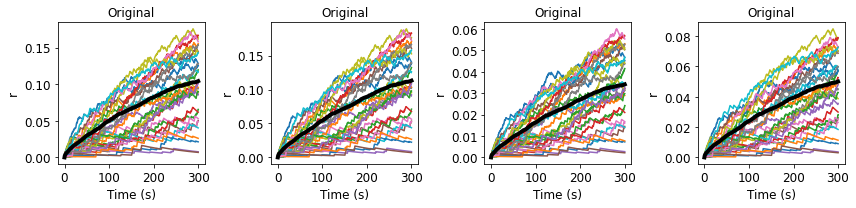

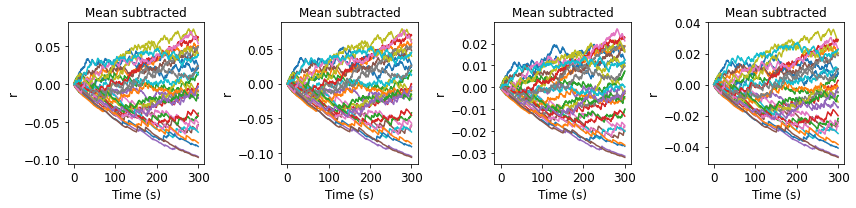

In [9]:
N_SEG_PLOT = 30
rs_mn = rs.mean(axis=0)
rs_mn_zero = rs - rs_mn

fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    ax.plot(t, rs_mn[:, cax], c='k', lw=4)
    set_plot(ax, x_label='Time (s)', y_label='r', title='Original')
    
fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs_mn_zero[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    set_plot(ax, x_label='Time (s)', y_label='r', title='Mean subtracted')
    
rs_mkv_mn = rs_mkv.mean(axis=0)
rs_mkv_mn_zero = rs_mkv - rs_mkv_mn

In [10]:
# compute rms displacement of zero-mean trajectories
rmsds = np.nan*np.zeros((nseg, len(t)))

for cseg in range(nseg):
    rmsds[cseg, :] = np.linalg.norm(rs_mn_zero[cseg, :, :], axis=1)
    
rmsd_mkvs = np.nan*np.zeros((nseg, len(t_mkv)))

for cseg in range(nseg):
    rmsd_mkvs[cseg, :] = np.linalg.norm(rs_mkv_mn_zero[cseg, : ,:], axis=1)

Slope = 0.7186109116692141
Slope = 0.46491776925872413


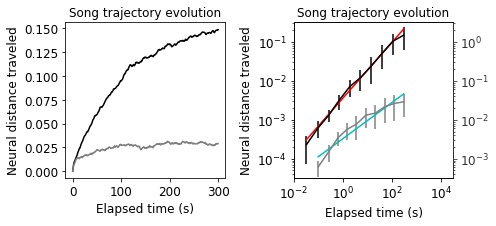

In [24]:
from disp import set_color

fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, rmsds.mean(0), c='k')
mt = np.round(np.logspace(0, np.log10(len(t)-1), 10)).astype(int)
axs[1].errorbar(t[mt], rmsds.mean(0)[mt], yerr=np.std(rmsds, axis=0)[mt], c='k')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], rmsds.mean(0)[t>0])
print(f'Slope = {slp}')

axs[1].plot(10**x_ln, 10**y_ln, c='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim(10**-4.5, 10**-0.5)

axs[0].plot(t_mkv, rmsd_mkvs.mean(0), c='gray')
mt_mkv = np.round(np.logspace(.5, np.log10(len(t_mkv)-1), 10)).astype(int)

ax_1_twin = axs[1].twinx()
ax_1_twin.errorbar(t_mkv[mt_mkv], rmsd_mkvs.mean(0)[mt_mkv], yerr=np.std(rmsd_mkvs, axis=0)[mt_mkv], c='gray')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t_mkv[mt_mkv], rmsd_mkvs.mean(0)[mt_mkv])
print(f'Slope = {slp}')

ax_1_twin.plot(10**x_ln, 10**y_ln, c='c')
ax_1_twin.set_xscale('log')
ax_1_twin.set_yscale('log')
ax_1_twin.set_ylim(10**-3.5, 10**.5)

set_plot(ax_1_twin)
set_color(ax_1_twin, (.2, .2, .2))

axs[1].set_xlim(10**-2, 10**4.5)

for ax in axs:
    set_plot(ax, x_label='Elapsed time (s)', y_label='Neural distance traveled', title='Song trajectory evolution')

# fig.savefig('ms/fig_5_song_trj_evolution.svg')

In [17]:
# song separation
NPAIR = 50

ds = np.nan*np.zeros((NPAIR, len(t)))
for cpair in range(NPAIR):
    idx_0, idx_1 = np.random.choice(np.arange(nseg), 2, replace=False)
    ds[cpair, :] = np.linalg.norm(rs[idx_0, :, :]-rs[idx_1, :, :], axis=1)
    
d_mkvs = np.nan*np.zeros((NPAIR, len(t_mkv)))
for cpair in range(NPAIR):
    idx_0, idx_1 = np.random.choice(np.arange(nseg), 2, replace=False)
    d_mkvs[cpair, :] = np.linalg.norm(rs_mkv[idx_0, :, :]-rs_mkv[idx_1, :, :], axis=1)

Slope = 0.7460911509353765
Slope = 0.5662757417576478


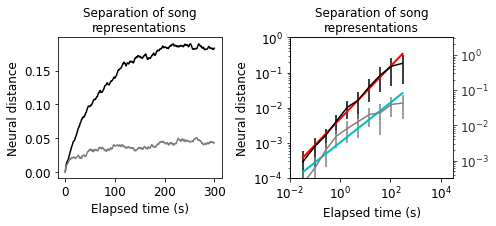

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, ds.mean(0), c='k')
axs[1].errorbar(t[mt], ds.mean(0)[mt], yerr=np.std(ds, axis=0)[mt], c='k')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], ds.mean(0)[t>0])
print(f'Slope = {slp}')

axs[1].plot(10**x_ln, 10**y_ln, c='r', lw=2)
axs[1].set_ylim(10**-4, 10**0)
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].plot(t_mkv, d_mkvs.mean(0), c='gray')
ax_1_twin = axs[1].twinx()
ax_1_twin.errorbar(t_mkv[mt_mkv], d_mkvs.mean(0)[mt_mkv], yerr=np.std(d_mkvs, axis=0)[mt_mkv], c='gray')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t_mkv[mt_mkv], d_mkvs.mean(0)[mt_mkv])
print(f'Slope = {slp}')

ax_1_twin.plot(10**x_ln, 10**y_ln, c='c', lw=2)
ax_1_twin.set_xscale('log')
ax_1_twin.set_yscale('log')
ax_1_twin.set_ylim(10**-3.5, 10**.5)

set_plot(ax_1_twin)
set_color(ax_1_twin, (.2, .2, .2))

axs[1].set_xlim(10**-2, 10**4.5)

for ax in axs:
    set_plot(ax, x_label='Elapsed time (s)', y_label='Neural distance', title='Separation of song\nrepresentations')

# fig.savefig('ms/fig_5_song_separation.svg')

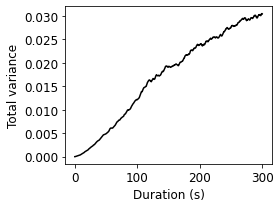

In [14]:
# compute how variance of point cloud changes over time
v = np.nan*np.zeros(len(t))
for ct in range(len(t)):
    v[ct] = np.trace(np.cov(rs[:, ct, :], rowvar=False))
    
# v_white = np.nan*np.zeros(len(t_white))
# for ct in range(len(t_white)):
#     v_white[ct] = np.trace(np.cov(rs_white[:, ct, :], rowvar=False))
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(t, v, c='k')
# ax.plot(t_white, v_white, c='gray')
set_plot(ax, x_label='Duration (s)', y_label='Total variance')

# fig.savefig('ms/fig_5_song_trj_variance.svg')